In [1]:
import numpy as np
import os 

np.random.seed(42)

import matplotlib 
import matplotlib.pyplot as plt


plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.filterwarnings(action = 'ignore', module="scipy", message="^internal gelsd")

In [2]:
np.random.seed(4)
m=60
w1,w2 =0.1,0.3
noise  =0.1

angles = np.random.rand(m) * 3*np.pi /2 -0.5
X = np.empty((m,3))
X[:,0] = np.cos(angles) + np.sin(angles)/2 +noise * np.random.randn(m)/2
X[:,1] = np.sin(angles)*0.7 + noise * np.random.randn(m)/2
X[:,2] =X[:,0] * w1 + X[:,1] * w2 + noise*np.random.randn(m)
# X

In [3]:
X_centered = X - X.mean(axis = 0)
U,s,Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]

In [4]:
m,n = X.shape
S = np.zeros(X_centered.shape)
S[:n,:n] = np.diag(s)

In [5]:
np.allclose(X_centered,U.dot(S).dot(Vt))

True

In [6]:
W2 =  Vt.T[:,:2]
X2D = X_centered.dot(W2)


In [7]:
X2D_using_svd = X2D

Sklearn 

In [8]:
from sklearn.decomposition import PCA

pca  = PCA(n_components =2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [11]:
np.allclose(X2D,-X2D_using_svd)

True

In [12]:
X3D_inv = pca.inverse_transform(X2D)

In [13]:
np.mean(np.sum(np.square(X3D_inv - X),axis = 1))

0.010170337792848549

In [14]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2,:])

In [15]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [16]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [17]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [18]:
1- pca.explained_variance_ratio_.sum()

0.011195535570688975

In [19]:
np.square(s)/np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [20]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


class Arrow3D(FancyArrowPatch):
    def __init__(self,xs,ys,zs,*args,**kwargs):
        FancyArrowPatch.__init__(self,(0,0),(0,0),*args,**kwargs)
        self._verts3d = xs,ys,zs
    
    def draw(self,renderer):
        xs3d,ys3d,zs3d = self._verts3d
        xs,ys,zs = proj3d.proj_transform(zs3d,ys3d,zs3d,renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self,renderer)

In [21]:
axes = [-1.8,1.8,-1.3,1.3,-1.0,1.0]
x1s = np.linspace(axes[0],axes[1],10)
x2s = np.linspace(axes[2],axes[3],10)
x1,x2 = np.meshgrid(x1s,x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0,2]*x1+R[1,2]* x2)/(1-R[2,2])

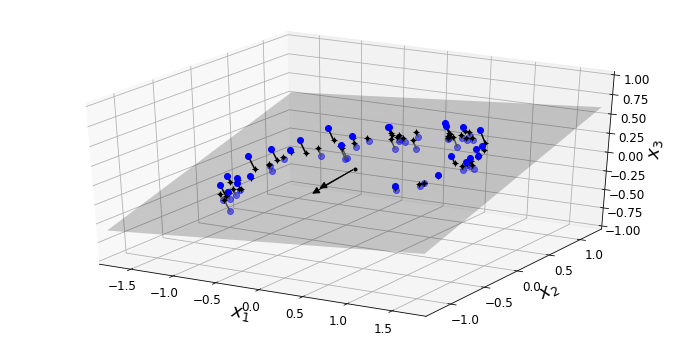

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111,projection ='3d')

X3D_above = X[X[:,2]>X3D_inv[:,2]]
X3D_below = X[X[:,2]<=X3D_inv[:,2]]

ax.plot(X3D_below[:,0],X3D_below[:,1],X3D_below[:,2],'bo',alpha =0.5)

ax.plot_surface(x1,x2,z,alpha = 0.2,color ='k')
np.linalg.norm(C,axis =0)
ax.add_artist(Arrow3D([0,C[0,0]],[0,C[0,1]],[0,C[0,2]]
                      ,mutation_scale = 15,lw=1
                      ,arrowstyle = '-|>',color ='k'))
ax.add_artist(Arrow3D([0,C[0,0]],[0,C[0,1]],[0,C[1,2]]
                      ,mutation_scale = 15,lw=1
                      ,arrowstyle = '-|>',color ='k'))
ax.plot([0],[0],[0],'k.')
for i in range(m):
    if X[i,2] >X3D_inv[i,2] :
        ax.plot([X[i][0],X3D_inv[i][0]],[X[i][1],X3D_inv[i][1]],
               [X[i][2],X3D_inv[i][2]],'k-')
    else:
        ax.plot([X[i][0],X3D_inv[i][0]],[X[i][1],X3D_inv[i][1]],
               [X[i][2],X3D_inv[i][2]],'k-',color="#505050")
        
ax.plot(X3D_inv[:,0],X3D_inv[:,1],X3D_inv[:,2],'k+')
ax.plot(X3D_inv[:,0],X3D_inv[:,1],X3D_inv[:,2],'k.')
ax.plot(X3D_above[:,0],X3D_above[:,1],X3D_above[:,2],'bo')
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()



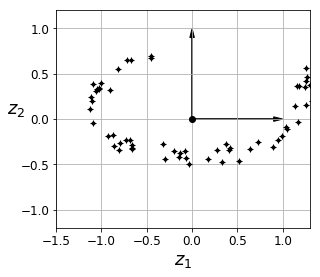

In [23]:
fig = plt.figure()
ax =fig.add_subplot(111,aspect = 'equal')

ax.plot(X2D[:,0],X2D[:,1],'k+')
ax.plot(X2D[:,0],X2D[:,1],'k.')
ax.plot([0],[0],'ko')
ax.arrow(0,0,0,1,head_width=0.05,
         length_includes_head = True
         ,head_length = 0.1,fc = 'k',ec ='k')
ax.arrow(0,0,1,0,head_width=0.05,
         length_includes_head = True
         ,head_length = 0.1,fc = 'k',ec ='k')
ax.set_xlabel('$z_1$',fontsize = 18)
ax.set_ylabel('$z_2$',fontsize = 18,rotation = 0)
ax.axis([-1.5,1.3,-1.2,1.2])
ax.grid(True)
plt.show()

In [24]:
from sklearn.datasets import make_swiss_roll
X,t = make_swiss_roll(n_samples = 1000,noise = 0.2,random_state = 42)

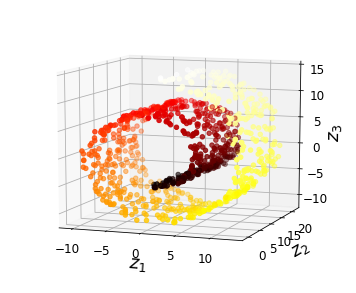

In [25]:
axes = [-11.5,14,-2,23,-12,15]

fig = plt.figure(figsize = (6,5))
ax = fig.add_subplot(111,projection = '3d')

ax.scatter(X[:,0],X[:,1],X[:,2],c=t,cmap = plt.cm.hot)
ax.view_init(10,-70)
ax.set_xlabel('$z_1$',fontsize = 18)
ax.set_ylabel('$z_2$',fontsize = 18)
ax.set_zlabel('$z_3$',fontsize = 18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

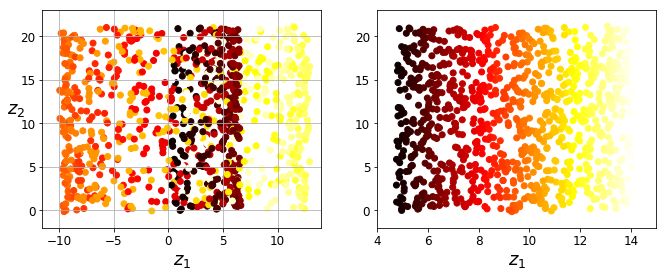

In [26]:
plt.figure(figsize = (11,4))

plt.subplot(121)
plt.scatter(X[:,0],X[:,1],c=t,cmap =plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$z_1$",fontsize = 18)
plt.ylabel('$z_2$',fontsize = 18,rotation = 0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t,X[:,1],c=t,cmap = plt.cm.hot)
plt.axis([4,15,axes[2],axes[3]])
plt.xlabel('$z_1$',fontsize =18)
plt.show()

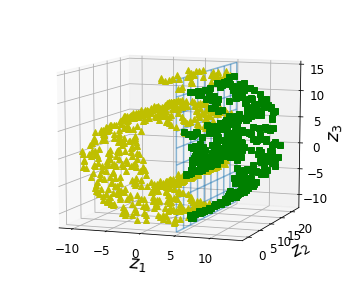

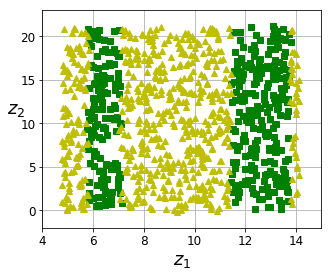

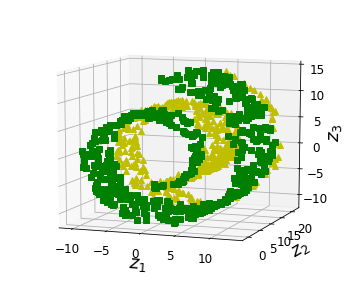

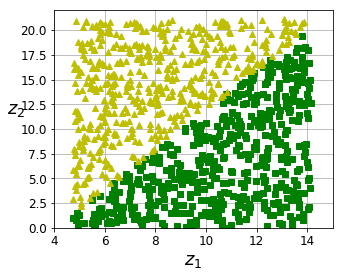

In [27]:
from matplotlib import gridspec

axes = [-11.5,14,-2,23,-12,15]

x2s = np.linspace(axes[2],axes[3],10)
x3s = np.linspace(axes[4],axes[5],10)
x2,x3 = np.meshgrid(x2s,x3s)

fig = plt.figure(figsize = (6,5))
ax = plt.subplot(111,projection ='3d')

positive_class = X[:,0]>5
X_pos = X[positive_class]
X_neg = X[~positive_class]

ax.view_init(10,-70)
ax.plot(X_neg[:,0],X_neg[:,1],X_neg[:,2],'y^')
ax.plot_wireframe(5,x2,x3,alpha =0.5)
ax.plot(X_pos[:,0],X_pos[:,1],X_pos[:,2],'gs')
ax.set_xlabel('$z_1$',fontsize = 18)
ax.set_ylabel('$z_2$',fontsize = 18)
ax.set_zlabel('$z_3$',fontsize = 18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize = (5,4))
ax = plt.subplot(111)

plt.plot(t[positive_class],X[positive_class,1],'gs')
plt.plot(t[~positive_class],X[~positive_class,1],'y^')
plt.axis([4,15,axes[2],axes[3]])
plt.xlabel("$z_1$",fontsize = 18)
plt.ylabel('$z_2$',fontsize = 18,rotation = 0)
plt.grid(True)
plt.show()


fig = plt.figure(figsize = (6,5))
ax = plt.subplot(111,projection ='3d')

positive_class =2*(t[:]-4)>X[:,1]
X_pos = X[positive_class]
X_neg = X[~positive_class]

ax.view_init(10,-70)
ax.plot(X_neg[:,0],X_neg[:,1],X_neg[:,2],'y^')
ax.plot(X_pos[:,0],X_pos[:,1],X_pos[:,2],'gs')
ax.set_xlabel('$z_1$',fontsize = 18)
ax.set_ylabel('$z_2$',fontsize = 18)
ax.set_zlabel('$z_3$',fontsize = 18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()


fig = plt.figure(figsize = (5,4))
ax = plt.subplot(111)

plt.plot(t[positive_class],X[positive_class,1],'gs')
plt.plot(t[~positive_class],X[~positive_class,1],'y^')
plt.axis([4,15,0,22],'b-',linewidth= 2)
plt.xlabel("$z_1$",fontsize = 18)
plt.ylabel('$z_2$',fontsize = 18,rotation = 0)
plt.grid(True)
plt.show()


PCA

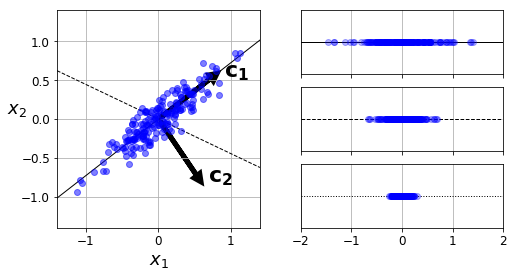

In [28]:
angle = np.pi/5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m,2)/10
X = X.dot(np.array([[stretch,0],[0,1]]))
X = X.dot([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]])

u1 = np.array([np.cos(angle),np.sin(angle)])
u2 = np.array([np.cos(angle-2*np.pi/6),np.sin(angle -2* np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2),np.sin(angle -np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1,1))
X_proj2 = X.dot(u2.reshape(-1,1))
X_proj3 = X.dot(u3.reshape(-1,1))

plt.figure(figsize =(8,4))
plt.subplot2grid((3,2),(0,0),rowspan = 3)
plt.plot([-1.4,1.4],[-1.4*u1[1]/u1[0],1.4*u1[1]/u1[0]],'k-',linewidth = 1)
plt.plot([-1.4,1.4],[-1.4*u2[1]/u2[0],1.4*u2[1]/u2[0]],'k--',linewidth = 1)
plt.plot([-1.4,1.4],[-1.4*u3[1]/u3[0],1.4*u3[1]/u3[0]],'k.',linewidth = 1)
plt.plot(X[:,0],X[:,1],'bo',alpha =0.5)
plt.axis([-1.4,1.4,-1.4,1.4])
plt.arrow(0,0,u1[0],u1[1],head_width =0.1,linewidth = 5,
         length_includes_head = True,head_length =0.1,
         fc = 'k',ec ='k')
plt.arrow(0,0,u3[0],u3[1],head_width =0.1,linewidth = 5,
         length_includes_head = True,head_length =0.1,
         fc = 'k',ec ='k')
plt.text(u1[0]+0.1,u1[1]-0.05,r'$\mathbf{c_1}$',fontsize = 22)
plt.text(u3[0]+0.1,u3[1],r'$\mathbf{c_2}$',fontsize = 22)
plt.xlabel('$x_1$',fontsize =18)
plt.ylabel('$x_2$',fontsize =18,rotation = 0)
plt.grid(True)


plt.subplot2grid((3,2),(0,1))
plt.plot([-2,2],[0,0],'k-',linewidth = 1)
plt.plot(X_proj1[:,0],np.zeros(m),'bo',alpha = 0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2,2,-1,1])
plt.grid(True)

plt.subplot2grid((3,2),(1,1))
plt.plot([-2,2],[0,0],'k--',linewidth = 1)
plt.plot(X_proj2[:,0],np.zeros(m),'bo',alpha = 0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2,2,-1,1])
plt.grid(True)

plt.subplot2grid((3,2),(2,1))
plt.plot([-2,2],[0,0],'k:',linewidth = 1)
plt.plot(X_proj3[:,0],np.zeros(m),'bo',alpha = 0.3)
plt.gca().get_yaxis().set_ticks([])
# plt.gca().get_xaxis().set_tickslabels([])
plt.axis([-2,2,-1,1])
plt.grid(True)

plt.show()

MNIST compression

In [29]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata

mnist  = fetch_mldata('MNIST original',data_home ='C:\\Users\\Administrator\\Desktop')

In [30]:
from sklearn.model_selection import train_test_split
X= mnist['data']
y =mnist['target']
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [31]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=0.95)+1

In [32]:
d

154

In [33]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)


In [34]:
pca.n_components_

154

In [35]:
np.sum(pca.explained_variance_ratio_)

0.9503623084769204

In [36]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [37]:
def plot_digits(instances,images_per_row = 5,**options):
    size = 28
    images_per_row = min(len(instances),images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) -1)//images_per_row+1
    row_images =[]
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size,size*n_empty)))
    for row in range(n_rows):
        rimages = images[row* images_per_row:(row+1)* images_per_row]
        row_images.append(np.concatenate(rimages, axis = 1))
    image = np.concatenate(row_images,axis = 0)
    plt.imshow(image,cmap = matplotlib.cm.binary,**options)
    plt.axis('off')

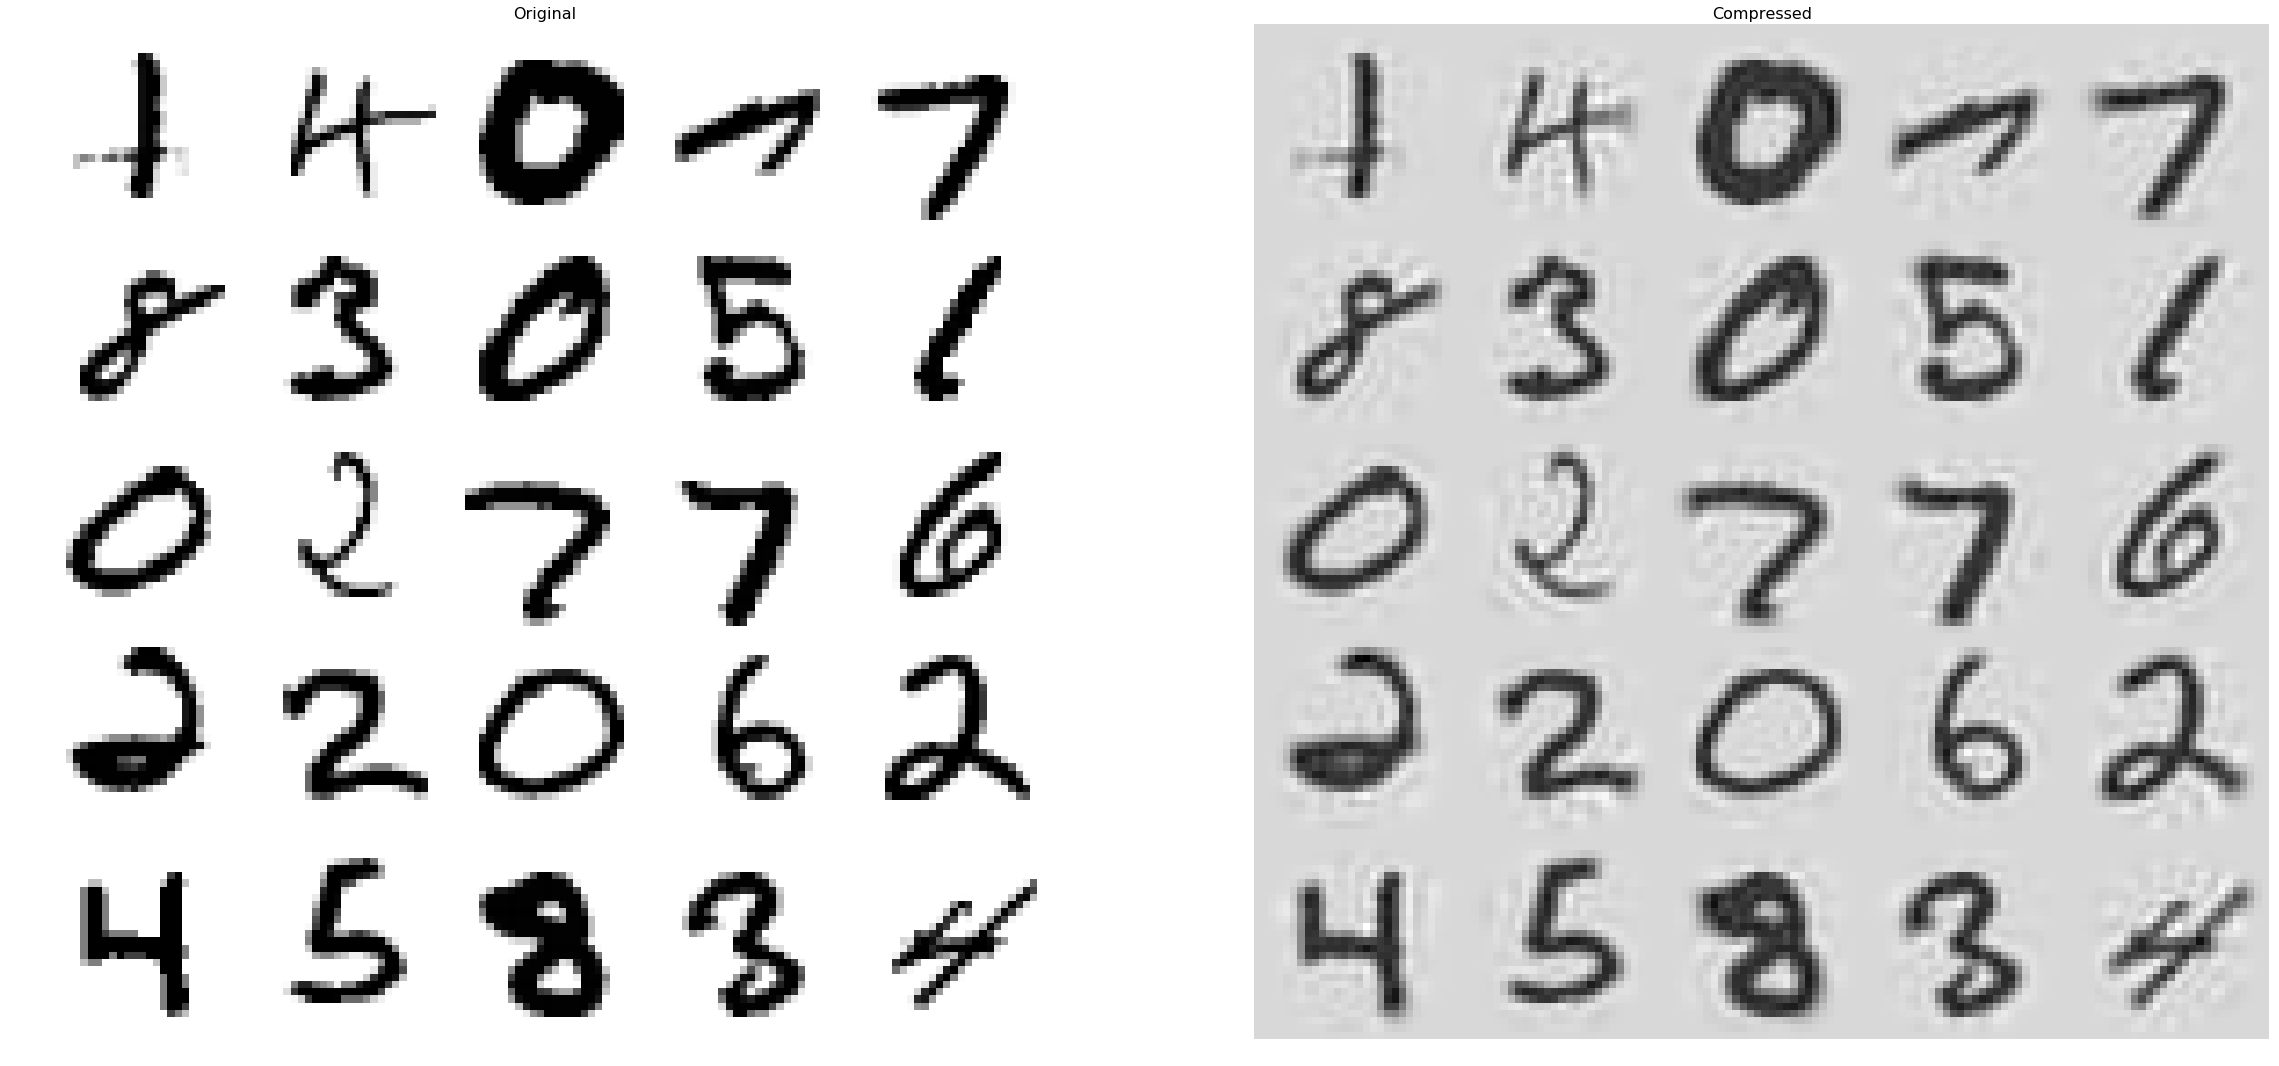

In [38]:
plt.figure(figsize = (40,40))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title('Original',fontsize = 16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title('Compressed',fontsize = 16)
plt.show()

In [39]:
X_reduced_pca = X_reduced

增量 PCA

In [40]:
from sklearn.decomposition import IncrementalPCA

n_batches =100
inc_pca = IncrementalPCA(n_components =154)
for X_batch in np.array_split(X_train,n_batches):
    print('.',end='')
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [41]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)



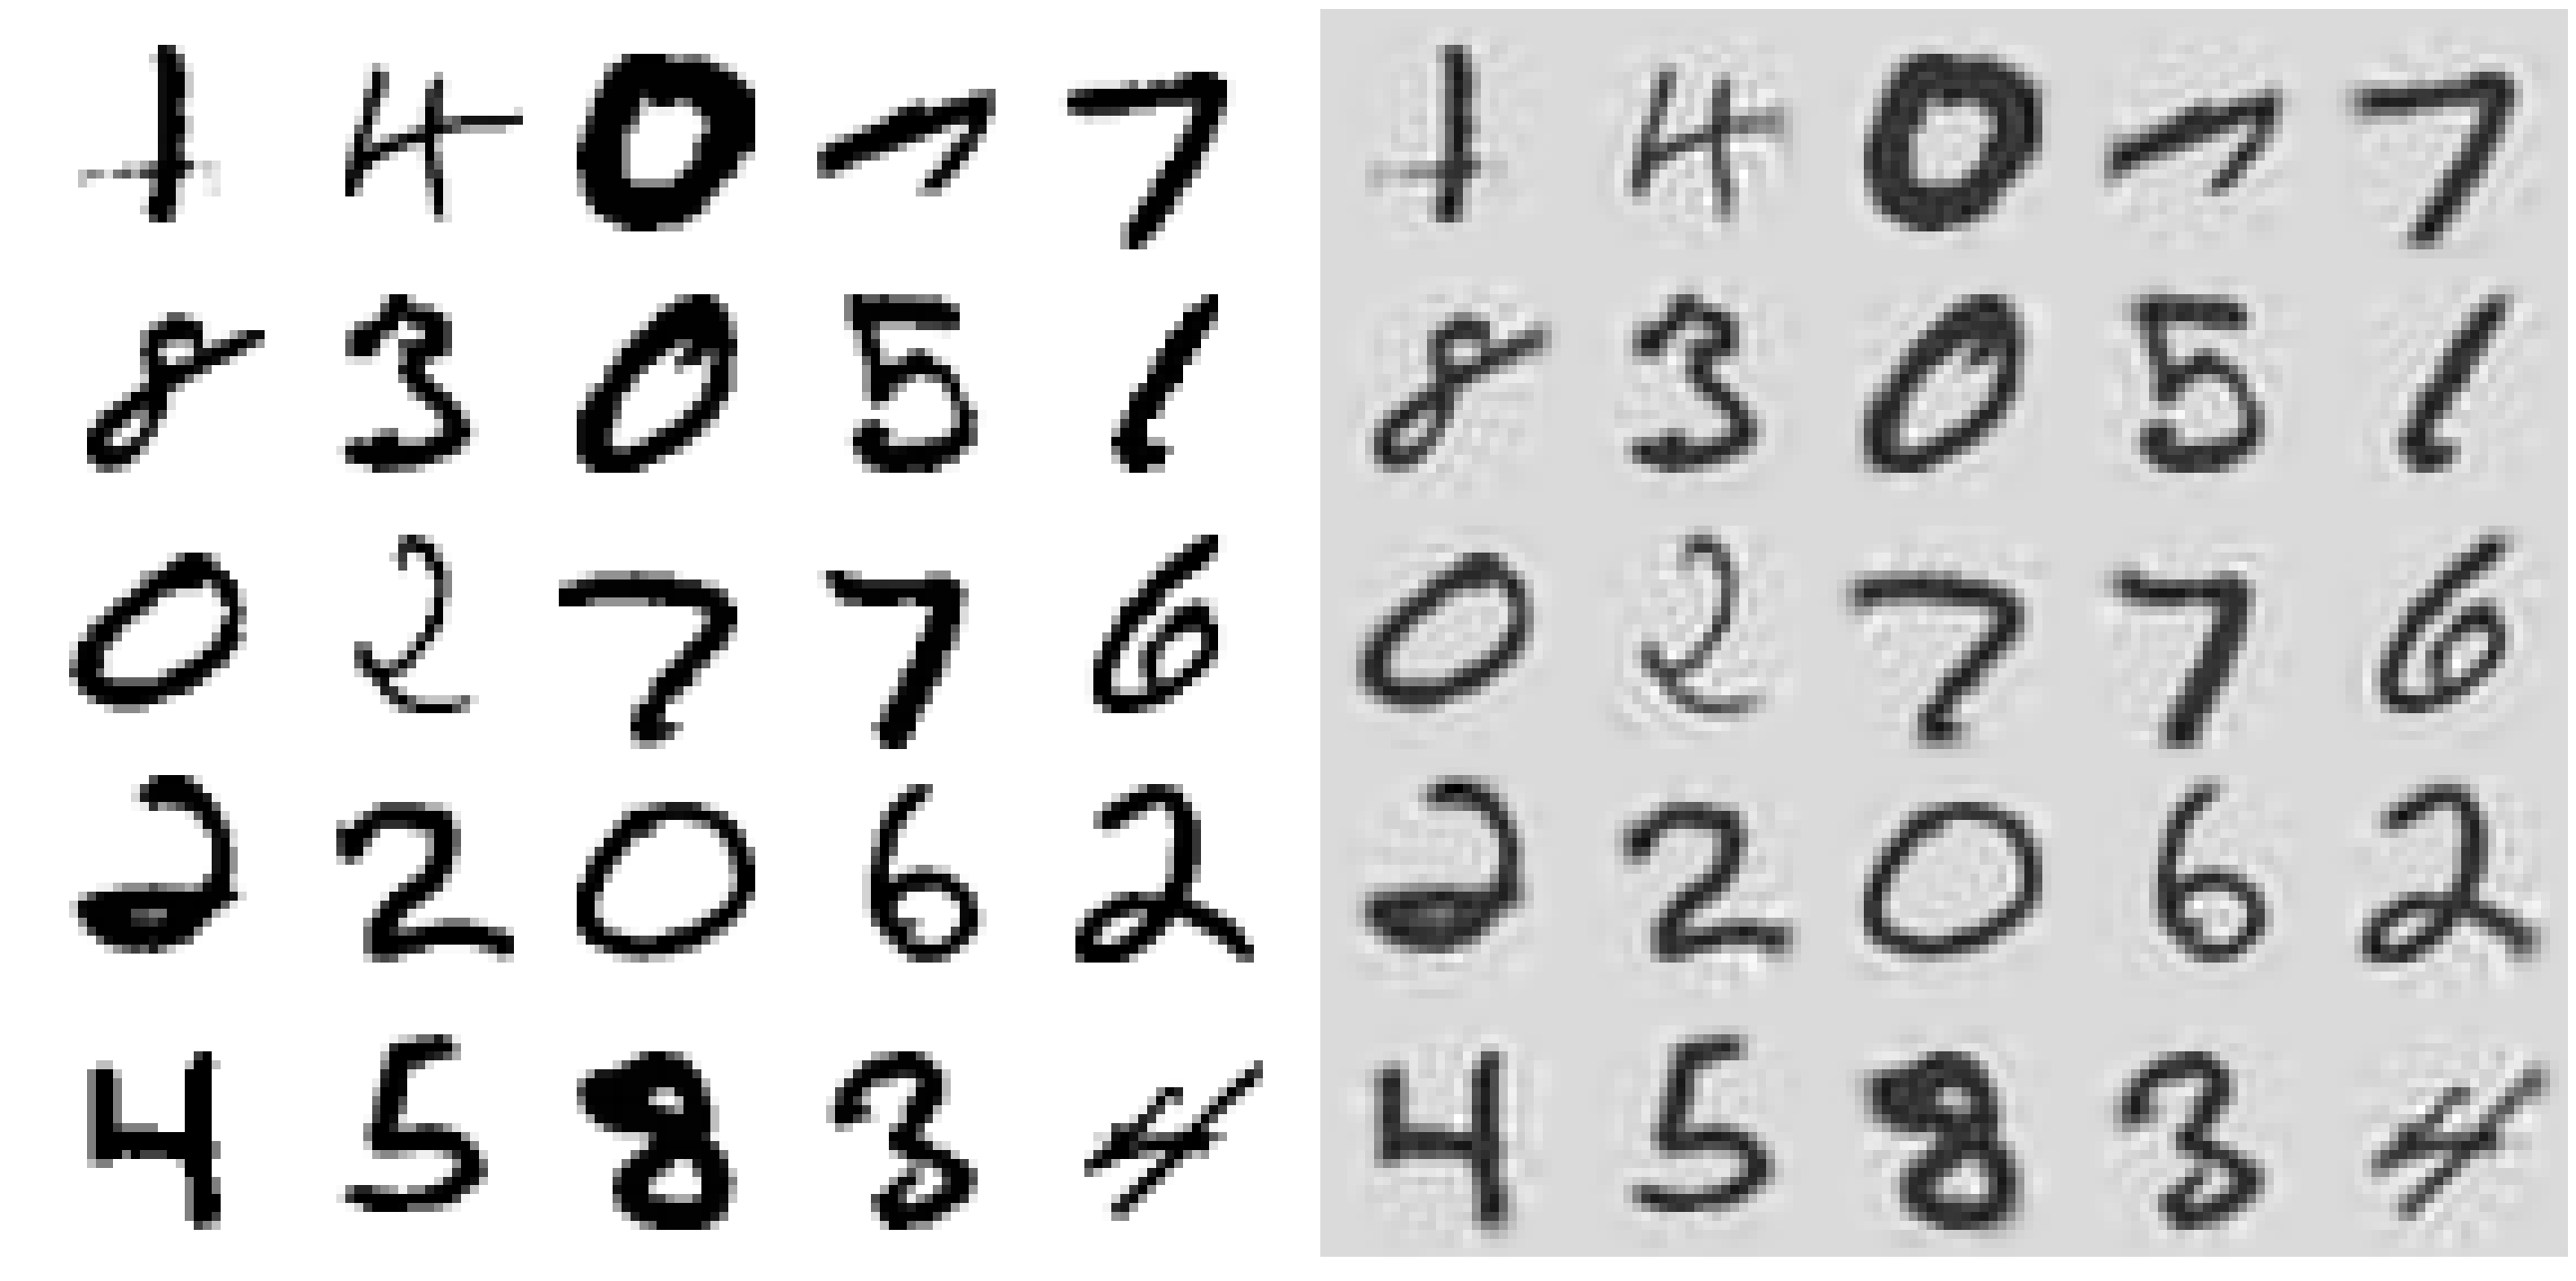

In [42]:
plt.figure(figsize=(40,40))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()
plt.show()

In [43]:
X_reduced_inc_pca = X_reduced

In [44]:
np.allclose(pca.mean_,inc_pca.mean_)

True

In [45]:
np.allclose(X_reduced_pca,X_reduced_inc_pca)

False

In [46]:
inc_pca.__class__.__name__

'IncrementalPCA'

时间比较

In [47]:
import time 

for n_components in (2,10,154):
    print('n_components=',n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components,batch_size=500)
    rnd_pca = PCA(n_components=n_components,random_state=42,svd_solver='randomized')
    
    for pca in (regular_pca,inc_pca,pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print(' {}:{:.1f} seconds'.format(pca.__class__.__name__,t2-t1))

n_components= 2
 PCA:17.3 seconds
 IncrementalPCA:20.3 seconds
 PCA:7.6 seconds
n_components= 10
 PCA:2.4 seconds
 IncrementalPCA:19.3 seconds
 PCA:7.8 seconds
n_components= 154
 PCA:8.0 seconds
 IncrementalPCA:31.7 seconds
 PCA:7.4 seconds


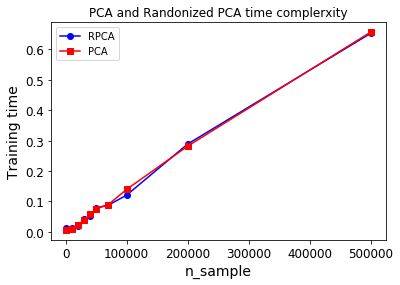

In [52]:
times_rpca = []
times_pca = []
sizes = [1000,10000,20000,30000,40000,50000,70000,100000,200000,500000]
for n_samples in sizes:
    X = np.random.randn(n_samples,5)
    pca = PCA(n_components = 2,svd_solver='randomized',random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2-t1)
    pca = PCA(n_components=2)
    t1 = time.time()
    pca.fit(X)
    t2= time.time()
    times_pca.append(t2-t1)
    
plt.plot(sizes,times_rpca,'b-o',label = 'RPCA')
plt.plot(sizes,times_pca,'r-s',label = 'PCA')
plt.xlabel('n_sample')
plt.ylabel('Training time')
plt.legend(loc='upper left')
plt.title('PCA and Randonized PCA time complerxity')
plt.show()
    

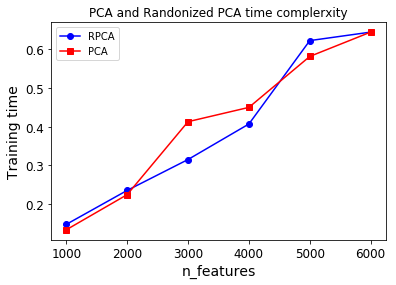

In [56]:
times_rpca = []
times_pca = []
sizes = [1000,2000,3000,4000,5000,6000]
for n_features in sizes:
    X = np.random.randn(2000,n_features)
    pca = PCA(n_components = 2,svd_solver='randomized',random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2-t1)
    pca = PCA(n_components=2)
    t1 = time.time()
    pca.fit(X)
    t2= time.time()
    times_pca.append(t2-t1)
    
plt.plot(sizes,times_rpca,'b-o',label = 'RPCA')
plt.plot(sizes,times_pca,'r-s',label = 'PCA')
plt.xlabel('n_features')
plt.ylabel('Training time')
plt.legend(loc='upper left')
plt.title('PCA and Randonized PCA time complerxity')
plt.show()
    

核 PCA（Kernel PCA）

In [57]:
X,t = make_swiss_roll(n_samples=1000,noise = 0.2,random_state=42)

from  sklearn.decomposition import KernelPCA

In [58]:
rbf_pca = KernelPCA(n_components=2,kernel='rbf',gamma = 0.04)
X_reduced  = rbf_pca.fit_transform(X)

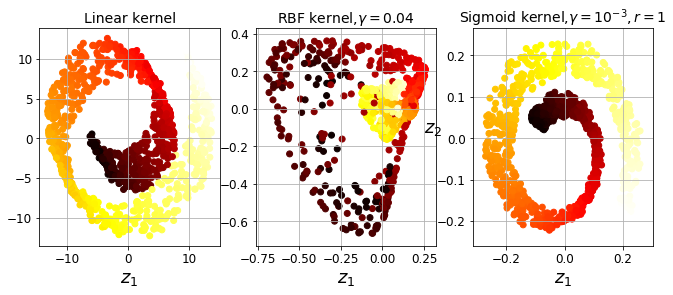

In [69]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components=2,kernel='linear',fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2,kernel='rbf',gamma=0.0433,fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2,kernel='sigmoid',gamma=0.001,coef0 = 1,fit_inverse_transform=True)

y=t>6.9

plt.figure(figsize = (11,4))
for subplot,pca,title in ((131,lin_pca,'Linear kernel'),
                        (132,rbf_pca,'RBF kernel,$\gamma = 0.04$'),
                         (133,sig_pca,'Sigmoid kernel,$\gamma=10^{-3},r=1$')):
    X_reduced =pca.fit_transform(X)
    if subplot ==132:
        X_reduced_rbf = X_reduced
    plt.subplot(subplot)
    plt.title(title,fontsize = 14)
    plt.scatter(X_reduced[:,0],X_reduced[:,1],c=t,cmap = plt.cm.hot)
    plt.xlabel('$z_1$',fontsize = 18)
    
    if subplot == 133:
        plt.ylabel("$z_2$",fontsize = 18,rotation = 0)
    plt.grid(True)
plt.show()

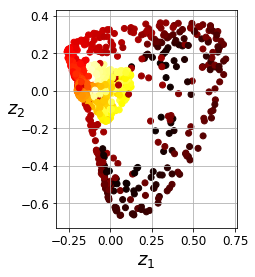

In [70]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize = (11,4))
plt.subplot(132)
plt.scatter(X_reduced[:,0],X_reduced[:,1],c=t,cmap = plt.cm.hot)
plt.xlabel('$z_1$',fontsize = 18)
plt.ylabel('$z_2$',fontsize = 18,rotation = 0)
plt.grid(True)
plt.show()

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca',KernelPCA(n_components=2)),
    ('log_reg',LogisticRegression())
])


param_grid = [{
    'kpca__gamma':np.linspace(0.03,0.05,10),
    'kpca__kernel':['rbf','sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [88]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [89]:
trnf_pca = KernelPCA(n_components=2,kernel='rbf',gamma=0.0433,fit_inverse_transform= True)

X_reduced =rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [90]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X,X_preimage)

32.786308795766125

LLE
局部线性嵌入（Locally Linear Embedding）是另一种非常有效的非线性降维（NLDR）方法。这是一种流形学习技术，不依赖于像以前算法那样的投影

In [91]:
X,t = make_swiss_roll(n_samples=1000,noise=0.2,random_state=42)


In [92]:
from sklearn.manifold import LocallyLinearEmbedding

lle =LocallyLinearEmbedding(n_components =2,n_neighbors = 10,random_state =41)
X_reduced = lle.fit_transform(X)

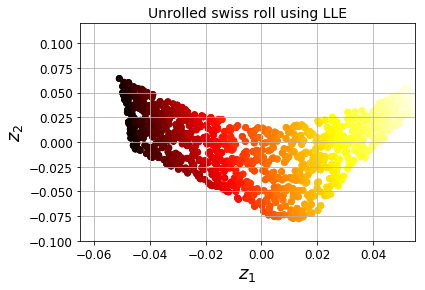

In [95]:
plt.title('Unrolled swiss roll using LLE',fontsize =14)
plt.scatter(X_reduced[:,0],X_reduced[:,1],c=t,cmap = plt.cm.hot)
plt.xlabel('$z_1$',fontsize = 18)
plt.ylabel('$z_2$',fontsize = 18)
plt.axis([-0.065,0.055,-0.1,0.12])
plt.grid(True)

plt.show()

MDS, Isomap and t-SNE

In [98]:
from sklearn.manifold import MDS

mds = MDS(n_components=2,random_state = 42)
X_reduced_mds = mds.fit_transform(X)

In [100]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [101]:
from sklearn.manifold import TSNE

tsne= TSNE(n_components=2,random_state = 42)
X_reduced_tsne = tsne.fit_transform(X)

In [104]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist['data']
y_mnist = mnist['target']
lda.fit(X_mnist,y_mnist)
X_reduced_lda = lda.transform(X_mnist)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


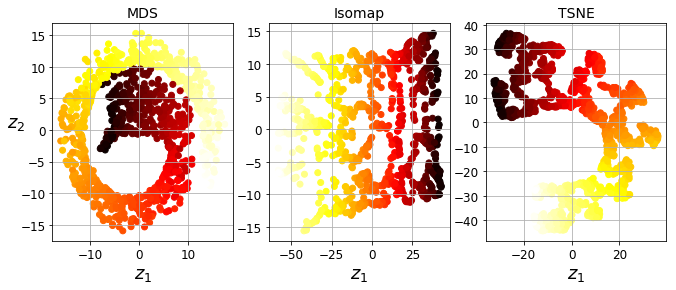

In [106]:
titles = ['MDS','Isomap','TSNE']

plt.figure(figsize = (11,4))

for subplot,title,X_reduced in zip((131,132,133),titles,
                                  (X_reduced_mds,X_reduced_isomap,X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title,fontsize = 14)
    plt.scatter(X_reduced[:,0],X_reduced[:,1],c=t,cmap = plt.cm.hot)
    plt.xlabel('$z_1$',fontsize =18)
    if subplot ==131:
        plt.ylabel('$z_2$',fontsize = 18,rotation = 0)
    plt.grid(True)
    
plt.show()

In [107]:
def learnrd_parameters(model):
    return [m for m in dir(model) 
           if m.endswith('_') and not m.startswith('_')]